In [1]:
import torch
import torchvision
import sklearn.metrics as metrics
import numpy as np
import sys
from torch.utils.data import Dataset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# COMP9444 Assignment 2

## Cat breed classification

## Neural Network

**student.py**

UNSW COMP9444 Neural Networks and Deep Learning

You may modify this file however you wish, including creating additional
variables, functions, classes, etc., so long as your code runs with the
hw2main.py file unmodified, and you are only using the approved packages.

You have been given some default values for the variables train_val_split,
batch_size as well as the transform function.
You are encouraged to modify these to improve the performance of your model.

**Answer to Question:**

Briefly describe how your program works, and explain any design and training
decisions you made along the way.

In [2]:
############################################################################
######     Specify transform(s) to be applied to the input images     ######
############################################################################

def transform(mode):
    """
    Called when loading the data. Visit this URL for more information:
    https://pytorch.org/vision/stable/transforms.html
    You may specify different transforms for training and testing
    """

    # channel size = 3

    if mode == 'train':
        return transforms.Compose(
            [   
                transforms.RandomResizedCrop(size=80, 
                         scale=(0.75, 1.0), ratio=(0.75, 1.3)), # original 80*80, avoid cropping important info
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation((-10,10)),
                transforms.ColorJitter(brightness=0.4, contrast=0.3, saturation=0.3, hue=0.2),
                transforms.RandomPosterize(bits=3, p=0.4),
                transforms.RandomEqualize(p=0.1),
                transforms.RandomGrayscale(p=0.1),
                transforms.RandomPerspective(distortion_scale=0.05, p=0.1, fill=0),
#                 T.RandomErasing(),
#                 T.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
#                 T.RandomInvert(p=0.05),
                transforms.ToTensor()
            ]
        )
    elif mode == 'test':
        return transforms.Compose(
            [   
                transforms.ToTensor()  # keep original training data to ensure accuracy  
            ]
        )

In [3]:
class SimpleCNN(nn.Module):

    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 30, kernel_size=5, padding=2),
            nn.BatchNorm2d(30), 
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            
            nn.Conv2d(30, 120, kernel_size=3),
            nn.BatchNorm2d(120), 
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            
            nn.Conv2d(120, 360, kernel_size=3),
            nn.BatchNorm2d(360), 
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            
            nn.Conv2d(360, 540, kernel_size=3),
            nn.BatchNorm2d(540), 
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
        )

        self.fc_layers = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(540*3*3, 1000),
            nn.BatchNorm1d(1000), 
            nn.ReLU(),
            
            nn.Dropout(p=0.4),
            nn.Linear(1000, 1000),
            nn.BatchNorm1d(1000), 
            nn.ReLU(),
            
            nn.Dropout(p=0.3),
            nn.Linear(1000, 8)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
#         print(x.shape)
        x = torch.flatten(x, start_dim=1)
        x = self.fc_layers(x)
        return x
    
    
net = SimpleCNN()
############################################################################
######      Specify the optimizer and loss function                   ######
############################################################################
learning_rate = 0.0004
# optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.5)
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
# loss_func = F.nll_loss
loss_func = nn.CrossEntropyLoss()

############################################################################
######  Custom weight initialization and lr scheduling are optional   ######
############################################################################

# Normally, the default weight initialization and fixed learing rate
# should work fine. But, we have made it possible for you to define
# your own custom weight initialization and lr scheduler, if you wish.
def weights_init(m):
    return

scheduler = None


In [4]:
############################################################################
#######              Metaparameters and training options              ######
############################################################################
dataset = "./data"
train_val_split = 0.8
batch_size = 64
epochs = 1000

## HW 2 Main

In [5]:
# Use a GPU if available, as it should be faster.
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


class DatasetFromSubset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)
    
    
# Test network on validation set, if it exists.
def test_network(net,testloader,print_confusion=False):
    net.eval()
    total_images = 0
    total_correct = 0
    conf_matrix = np.zeros((8,8))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            conf_matrix = conf_matrix + metrics.confusion_matrix(
                labels.cpu(),predicted.cpu(),labels=[0,1,2,3,4,5,6,7])

    model_accuracy = total_correct / total_images * 100
    print(', {0} test {1:.2f}%'.format(total_images,model_accuracy))
    if print_confusion:
        np.set_printoptions(precision=2, suppress=True)
        print(conf_matrix)
    net.train()

Using device: cuda:0

test data distribution - {0: 783, 1: 798, 2: 820, 3: 793, 4: 804, 5: 799, 6: 814, 7: 789}
first item in last batch, label 4 - Siamese


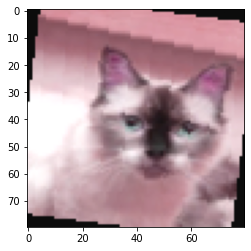

second item in last batch, label 2 - Persian


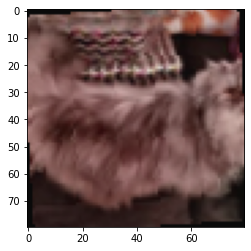

last item in last batch, label 1 - Calico


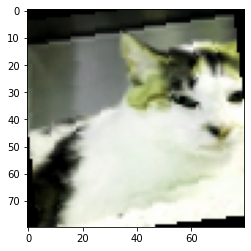

torch.Size([3, 80, 80])
batch size: 64
learning rate: 0.0004
train_val_split: 0.8
epochs: 350
Compose(
    RandomResizedCrop(size=(80, 80), scale=(0.75, 1.0), ratio=(0.75, 1.3), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
    ColorJitter(brightness=[0.6, 1.4], contrast=[0.7, 1.3], saturation=[0.7, 1.3], hue=[-0.2, 0.2])
    RandomPosterize(bits=3,p=0.4)
    RandomEqualize(p=0.1)
    RandomGrayscale(p=0.1)
    RandomPerspective(p=0.1)
    ToTensor()
)
SimpleCNN(
  (conv_layers): Sequential(
    (0): Conv2d(3, 30, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(30, 120, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(120, eps=1e-05, momentum=0.1, affine=True, track_run

ep 52, loss: 61.73, 6400 train 78.08%, 1600 test 72.00%
ep 53, loss: 63.70, 6400 train 76.73%, 1600 test 70.06%
ep 54, loss: 62.24, 6400 train 78.31%, 1600 test 71.81%
ep 55, loss: 60.57, 6400 train 78.41%, 1600 test 72.00%
ep 56, loss: 60.06, 6400 train 78.27%, 1600 test 69.31%
ep 57, loss: 59.30, 6400 train 78.45%, 1600 test 65.00%
ep 58, loss: 57.51, 6400 train 79.31%, 1600 test 65.62%
ep 59, loss: 57.12, 6400 train 79.22%, 1600 test 68.75%
ep 60, loss: 58.12, 6400 train 79.20%, 1600 test 69.12%
[[182.   0.   1.   7.   2.   1.  24.   0.]
 [  3.  64.   0.  16.  24.  34.  44.  17.]
 [  8.   3.  79.  26.  25.  13.  17.   9.]
 [ 19.   0.   2. 173.   2.   5.   5.   1.]
 [  2.   2.   2.  36. 139.   6.   4.   5.]
 [  2.   0.   1.  16.   0. 176.   4.   2.]
 [ 11.   6.   1.   8.   2.  24. 132.   2.]
 [ 22.   5.   0.   8.   4.   3.   8. 161.]]
   Model saved to checkModel.pth
ep 61, loss: 57.80, 6400 train 79.72%, 1600 test 72.31%
ep 62, loss: 55.49, 6400 train 80.61%, 1600 test 71.00%
ep 63,

ep 141, loss: 26.77, 6400 train 90.91%, 1600 test 75.69%
ep 142, loss: 24.90, 6400 train 91.47%, 1600 test 76.31%
ep 143, loss: 27.34, 6400 train 90.28%, 1600 test 77.81%
ep 144, loss: 28.01, 6400 train 90.55%, 1600 test 74.44%
ep 145, loss: 27.52, 6400 train 90.83%, 1600 test 75.06%
ep 146, loss: 25.33, 6400 train 91.30%, 1600 test 75.56%
ep 147, loss: 26.60, 6400 train 90.98%, 1600 test 76.81%
ep 148, loss: 26.22, 6400 train 90.98%, 1600 test 73.06%
ep 149, loss: 26.16, 6400 train 90.83%, 1600 test 76.88%
ep 150, loss: 26.95, 6400 train 90.70%, 1600 test 73.88%
[[184.   1.   1.  16.   5.   2.   6.   2.]
 [  2.  78.   8.  12.  22.  45.  26.   9.]
 [  5.   2. 123.   7.  12.  21.   4.   6.]
 [ 10.   0.   2. 182.   3.   9.   0.   1.]
 [  1.   3.   9.   6. 162.  11.   1.   3.]
 [  2.   1.   4.   3.   0. 189.   0.   2.]
 [ 18.   6.   7.  11.   0.  36. 107.   1.]
 [ 16.   8.   4.  13.   5.   5.   3. 157.]]
   Model saved to checkModel.pth
ep 151, loss: 27.01, 6400 train 90.88%, 1600 test 76

ep 231, loss: 17.32, 6400 train 94.20%, 1600 test 76.12%
ep 232, loss: 17.34, 6400 train 94.28%, 1600 test 78.81%
ep 233, loss: 16.12, 6400 train 94.48%, 1600 test 77.81%
ep 234, loss: 17.00, 6400 train 94.09%, 1600 test 76.19%
ep 235, loss: 17.13, 6400 train 94.12%, 1600 test 76.38%
ep 236, loss: 16.48, 6400 train 94.28%, 1600 test 76.06%
ep 237, loss: 15.94, 6400 train 94.48%, 1600 test 77.38%
ep 238, loss: 15.92, 6400 train 94.78%, 1600 test 75.50%
ep 239, loss: 14.46, 6400 train 94.75%, 1600 test 77.88%
ep 240, loss: 16.64, 6400 train 94.50%, 1600 test 75.12%
[[176.   0.   0.  18.   1.   1.   9.  12.]
 [  1. 112.   1.   6.  10.  20.  28.  24.]
 [  7.  17.  92.  19.   9.  17.  10.   9.]
 [  6.   1.   1. 185.   1.   5.   5.   3.]
 [  1.  16.   4.  21. 135.   8.   3.   8.]
 [  1.   2.   0.  10.   0. 179.   6.   3.]
 [  9.  12.   0.   6.   0.  14. 142.   3.]
 [  9.  13.   1.   4.   0.   0.   3. 181.]]
   Model saved to checkModel.pth
ep 241, loss: 15.13, 6400 train 95.00%, 1600 test 77

In [ ]:
# Cat breed dictionary 
cat_dict = {
    0: 'Bombay',
    1: 'Calico',
    2: 'Persian',
    3: 'Russian Blue',
    4: 'Siamese',
    5: 'Tiger',
    6: 'Tortoiseshell',
    7: 'Tuxedo'
}

# Main
print("Using device: {}"
      "\n".format(str(device)))
########################################################################
#######                      Loading Data                        #######
########################################################################
data = torchvision.datasets.ImageFolder(root=dataset)

if train_val_split == 1:
    # Train on the entire dataset
    data = torchvision.datasets.ImageFolder(root=dataset,
                        transform=transform('train'))
    trainloader = torch.utils.data.DataLoader(data,
                        batch_size=batch_size, shuffle=True);
else:
    # Split the dataset into trainset and testset
    data = torchvision.datasets.ImageFolder(root=dataset)
    data.len=len(data)
    train_len = int((train_val_split)*data.len)
    test_len = data.len - train_len
    train_subset, test_subset = random_split(data, [train_len, test_len])
    trainset = DatasetFromSubset(
        train_subset, transform=transform('train'))
    testset = DatasetFromSubset(
        test_subset, transform=transform('test'))

    trainloader = torch.utils.data.DataLoader(trainset, 
                        batch_size=batch_size, shuffle=False)
    testloader = torch.utils.data.DataLoader(testset, 
                        batch_size=batch_size, shuffle=False)

#########################
#**     REMOVABLE     **#
#########################
# Getting count of each cat breed, should be close to 0.8*1000 each--
total = 0
counter_dict = {0:0, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0}
for data in trainloader:
    Xs, ys = data
    for y in ys:
        counter_dict[(int(y))] += 1
        total += 1
print(f'test data distribution - {counter_dict}')
# print(Xs) # last batch in our iteration size = 200 by default
# print(ys) # last batch (labels) in our iteration size = 200 by default
# https://stackoverflow.com/questions/53623472/how-do-i-display-a-single-image-in-pytorch/53633017
print(f'first item in last batch, label {ys[0]} - {cat_dict[ys.numpy()[0]]}')
plt.imshow(Xs[0].permute(1, 2, 0))
plt.show()
print(f'second item in last batch, label {ys[1]} - {cat_dict[ys.numpy()[1]]}')
plt.imshow(Xs[1].permute(1, 2, 0))
plt.show()
print(f'last item in last batch, label {ys[-1]} - {cat_dict[ys.numpy()[-1]]}')
plt.imshow(Xs[-1].permute(1, 2, 0))
plt.show()
print(Xs[0].shape)

## https://stackoverflow.com/questions/60101240/finding-mean-and-standard-deviation-across-image-channels-pytorch

# from torch.utils.data import TensorDataset, DataLoader

# nimages = 0
# mean = 0.0
# var = 0.0
# for i_batch, batch_target in enumerate(trainloader):
#     batch = batch_target[0]
#     # Rearrange batch to be the shape of [B, C, W * H]
#     batch = batch.view(batch.size(0), batch.size(1), -1)
#     # Update total number of images
#     nimages += batch.size(0)
#     # Compute mean and std here
#     mean += batch.mean(2).sum(0) 
#     var += batch.var(2).sum(0)

# mean /= nimages
# var /= nimages
# std = torch.sqrt(var)

# print('mean')
# print(mean)
# print('std')
# print(std)

#############################
#**     REMOVABLE END     **#
#############################

# Get model, loss criterion and optimizer from student
net = net.to(device)

#########################
#**    REMOVABLE_2    **#
#########################
print(f'batch size: {batch_size}')
print(f'learning rate: {learning_rate}')
print(f'train_val_split: {train_val_split}')
print(f'epochs: {epochs}')

print(transform('train'))

print(net)
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
count_parameters(net)
#############################
#**    REMOVABLE_2 END    **#
#############################

criterion = loss_func
optimizer = optimizer
# get weight initialization and lr scheduler, if appropriate
weights_init = weights_init
scheduler = scheduler

# apply custom weight initialization, if it exists
net.apply(weights_init)

########################################################################
#######                        Training                          #######
########################################################################
print("Start training...")
for epoch in range(1,epochs+1):
    total_loss = 0
    total_images = 0
    total_correct = 0

    for batch in trainloader:           # Load batch
        images, labels = batch 
        images = images.to(device)
        labels = labels.to(device)

        preds = net(images)             # Process batch

        loss = criterion(preds, labels) # Calculate loss

        optimizer.zero_grad()
        loss.backward()                 # Calculate gradients
        optimizer.step()                # Update weights

        output = preds.argmax(dim=1)

        total_loss += loss.item()
        total_images += labels.size(0)
        total_correct += output.eq(labels).sum().item()

    # apply lr schedule, if it exists
    if scheduler is not None:
        scheduler.step()

    model_accuracy = total_correct / total_images * 100
    print('ep {0}, loss: {1:.2f}, {2} train {3:.2f}%'.format(
           epoch, total_loss, total_images, model_accuracy), end='')

    if train_val_split < 1:
        test_network(net,testloader,
                     print_confusion=(epoch % 10 == 0))
    else:
        print()

    if epoch % 10 == 0:
        torch.save(net.state_dict(),'checkModel.pth')
        print("   Model saved to checkModel.pth")        

    sys.stdout.flush()

torch.save(net.state_dict(),'savedModel.pth')
print("   Model saved to savedModel.pth")

### Analysis